In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imcascade.fitter import initialize_fitter
from imcascade.results import ImcascadeResults
from imcascade.psf_fitter import PSFFitter
from imcascade import Fitter
import sep

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


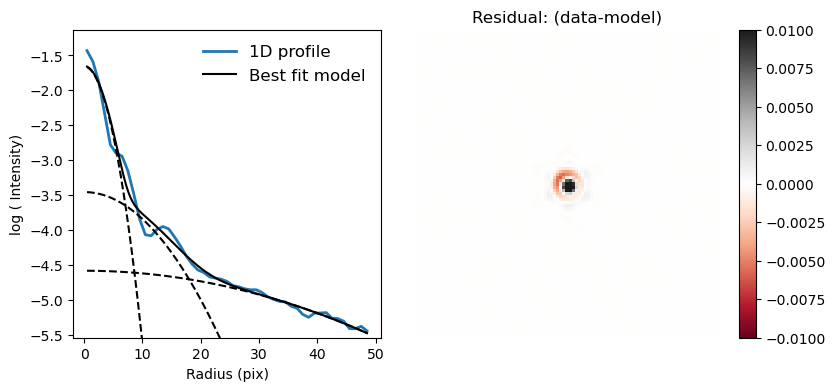

In [2]:
# Load data
galaxy_data = fits.getdata('simulated_galaxy_0.fits')

psf_data = fits.getdata('/Users/nasekhian/Documents/GitHub/IMcascade/ePSFf444w.fits')
sci = fits.getdata('sci_convolved_0.fits')[535-200:535+200,202-200:202+200]
var = fits.getdata('variance_bkg_0.fits')[535-200:535+200,202-200:202+200]
mask_raw = fits.getdata('segmentation_map_0.fits')[535-200:535+200,202-200:202+200]
# Set up PSF fitting
psf_fitter = PSFFitter(psf_data, oversamp=1)
psf_sig, psf_a, chi2, fig = psf_fitter.fit_N(3, plot=True)  # adjust the number of component

In [3]:
ID = mask_raw[200,200]
ID

290

Text(0.5, 1.0, 'Variance Image')

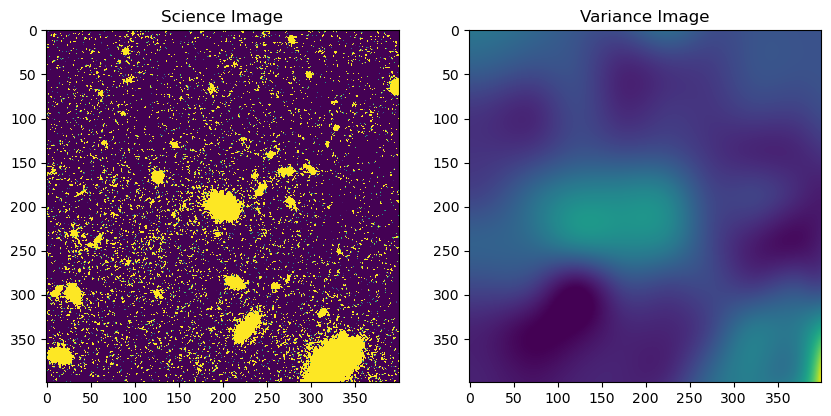

In [4]:
#Let's take a look at the data quickly, everything looks pretty good!
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(sci, vmin =np.min(var) , vmax = np.max(var))
ax1.set_title('Science Image')
ax2.imshow(var,vmin =np.min(var) , vmax = np.max(var))
ax2.set_title('Variance Image')


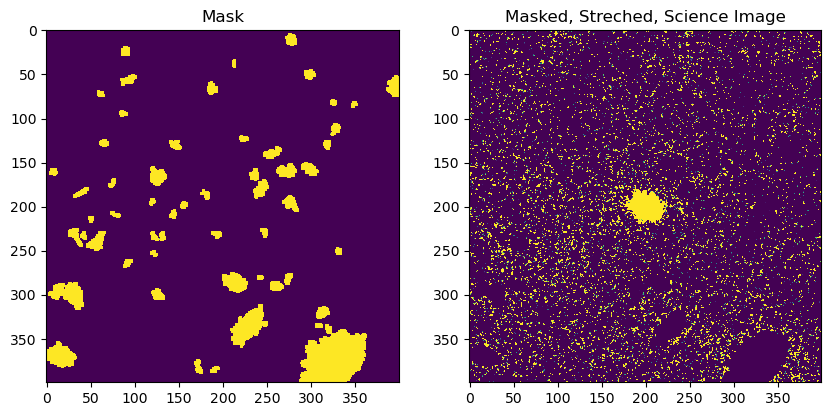

In [6]:

mask_raw[np.where(mask_raw == ID)] = 0
mask_raw = mask_raw > 0

#Convolve mask with a gaussian to expand it and make sure that all low-SB emission is masked
from imcascade.utils import expand_mask
mask = expand_mask(mask_raw, radius = 0.5)
mask = np.array(mask, dtype = bool)


fig, (ax1,ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.imshow(mask, vmin =np.min(var) , vmax = np.max(var))
ax1.set_title('Mask')
ax2.imshow(sci*np.logical_not(mask),vmin =np.min(var) , vmax = np.max(var))
ax2.set_title('Masked, Streched, Science Image')
plt.show()

In [7]:
sig = np.logspace(np.log10(1),np.log10(50), num = 9)
init_dict  = {'re':5, 'flux': 1.5}

In [8]:
from imcascade import Fitter

fitter = Fitter(sci,sig, psf_sig, psf_a, weight = var, mask = mask, init_dict = init_dict, log_file = 'examp.log' )

min_res = fitter.run_ls_min()

2024-04-22 16:04:21,598 - Running least squares minimization
2024-04-22 16:04:39,877 - Finished least squares minimization


In [9]:
min_res

array([ 2.01164186e+02,  2.00200094e+02,  4.63035837e-01,  1.08901050e+00,
       -5.82521937e-01, -4.93336011e-01, -7.24408569e-01, -8.27607436e-01,
       -3.56584477e-01, -6.19954531e-01, -1.53610615e+00, -2.65204262e+00,
       -4.08307988e+00, -2.64722798e-06,  6.32329717e-08, -3.36849822e-08])

In [10]:
import pandas as pd

# Define column names based on the components of the array
column_names = ['x0', 'y0', 'axis_ratio', 'position_angle']

# Add column names for the flux or weight of each Gaussian component
column_names.extend([f'flux_{i}' for i in range(1, 10)])

# Add column names for the sky model components
column_names.extend([f'sky_{i}' for i in range(1, 4)])

# Create a DataFrame from the array with column names
df = pd.DataFrame([min_res], columns=column_names)

# Display the DataFrame
print(df)

           x0          y0  axis_ratio  position_angle    flux_1    flux_2  \
0  201.164186  200.200094    0.463036        1.089011 -0.582522 -0.493336   

     flux_3    flux_4    flux_5    flux_6    flux_7    flux_8   flux_9  \
0 -0.724409 -0.827607 -0.356584 -0.619955 -1.536106 -2.652043 -4.08308   

      sky_1         sky_2         sky_3  
0 -0.000003  6.323297e-08 -3.368498e-08  


/Users/nasekhian/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/var/folders/xm/sl735y1n4m30kfvcxl7h4p6w0000gn/T/ipykernel_39223/4214590594.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


/Users/nasekhian/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/lib/function_base.py:4823: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/Users/nasekhian/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/imcascade-1.1-py3.10.egg/imcascade/results.py:709: RuntimeWarning: divide by zero encountered in divide


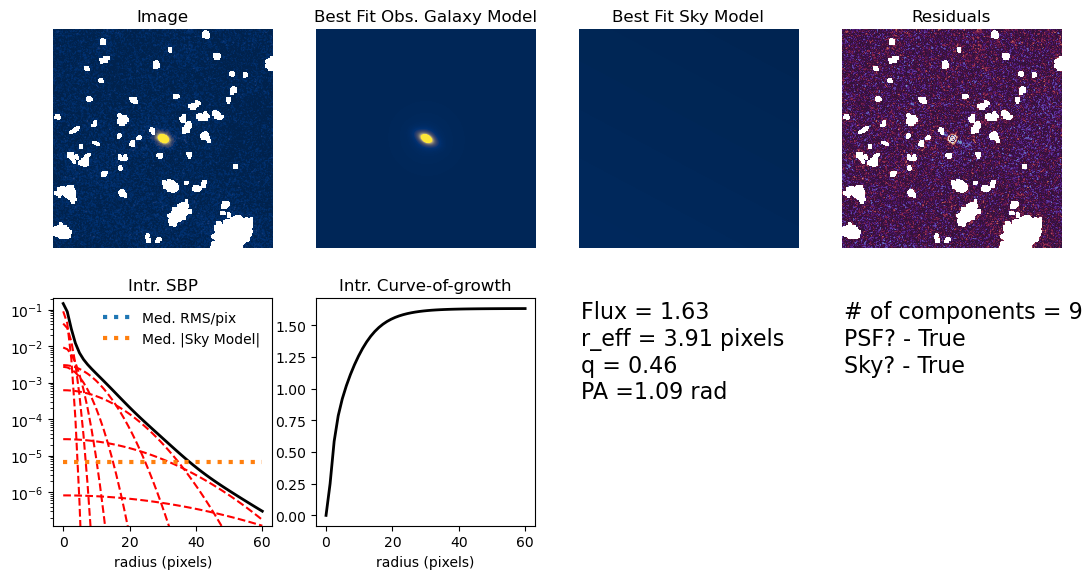

In [11]:
from imcascade import ImcascadeResults

#Initialized using `imcascade.Fitter.fitter` instance
res_class = ImcascadeResults(fitter)
fig = res_class.make_diagnostic_fig()

In [12]:
dyn_expsave_resultst = fitter.run_dynesty(method = 'express')
fitter.save_results('./examp_results.asdf')

2024-04-22 16:05:08,109 - Running dynesty using the express method
2024-04-22 16:05:08,110 - Setting up pre-rendered images
2024-04-22 16:05:08,111 - Parameters to be set for pre-rendered images:
2024-04-22 16:05:08,111 - 	 Galaxy Center: 201.16,200.20
2024-04-22 16:05:08,112 - 	 Axis Ratio: 0.46304
2024-04-22 16:05:08,112 - 	 PA: 1.08901


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1841it [00:37, 27.33it/s, batch: 0 | bound: 1 | nc: 32 | ncall: 18137 | eff(%):  9.878 | loglstar:   -inf < -844587.393 <    inf | logz: -844589.677 +/-  0.050 | dlogz:  0.339 >  0.010] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1910it [00:39, 26.78it/s, batch: 0 | bound: 2 | nc: 32 | ncall: 20345 | eff(%):  9.163 | loglstar:   -inf < -844587.340 <    inf | logz: -844589.645 +/-  0.050 | dlogz:  0.293 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


1983it [00:42, 27.41it/s, batch: 0 | bound: 3 | nc: 32 | ncall: 22681 | eff(%):  8.554 | loglstar:   -inf < -844587.298 <    inf | logz: -844589.615 +/-  0.050 | dlogz:  0.251 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2061it [00:45, 26.92it/s, batch: 0 | bound: 4 | nc: 32 | ncall: 25177 | eff(%):  8.027 | loglstar:   -inf < -844587.259 <    inf | logz: -844589.587 +/-  0.050 | dlogz:  0.213 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2135it [00:48, 26.49it/s, batch: 0 | bound: 5 | nc: 32 | ncall: 27545 | eff(%):  7.613 | loglstar:   -inf < -844587.227 <    inf | logz: -844589.564 +/-  0.050 | dlogz:  0.182 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2208it [00:50, 26.28it/s, batch: 0 | bound: 6 | nc: 32 | ncall: 29881 | eff(%):  7.268 | loglstar:   -inf < -844587.195 <    inf | logz: -844589.544 +/-  0.050 | dlogz:  0.157 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2284it [00:53, 24.39it/s, batch: 0 | bound: 7 | nc: 32 | ncall: 32313 | eff(%):  6.961 | loglstar:   -inf < -844587.163 <    inf | logz: -844589.526 +/-  0.050 | dlogz:  0.134 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2359it [00:56, 21.43it/s, batch: 0 | bound: 8 | nc: 32 | ncall: 34713 | eff(%):  6.699 | loglstar:   -inf < -844587.134 <    inf | logz: -844589.511 +/-  0.050 | dlogz:  0.114 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2434it [00:59, 25.39it/s, batch: 0 | bound: 9 | nc: 32 | ncall: 37113 | eff(%):  6.471 | loglstar:   -inf < -844587.112 <    inf | logz: -844589.497 +/-  0.050 | dlogz:  0.098 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2509it [01:02, 25.28it/s, batch: 0 | bound: 10 | nc: 32 | ncall: 39513 | eff(%):  6.270 | loglstar:   -inf < -844587.090 <    inf | logz: -844589.485 +/-  0.050 | dlogz:  0.084 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2584it [01:05, 23.42it/s, batch: 0 | bound: 11 | nc: 32 | ncall: 41913 | eff(%):  6.092 | loglstar:   -inf < -844587.073 <    inf | logz: -844589.475 +/-  0.050 | dlogz:  0.072 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2658it [01:08, 25.58it/s, batch: 0 | bound: 12 | nc: 32 | ncall: 44281 | eff(%):  5.936 | loglstar:   -inf < -844587.059 <    inf | logz: -844589.466 +/-  0.050 | dlogz:  0.062 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2735it [01:11, 24.59it/s, batch: 0 | bound: 13 | nc: 32 | ncall: 46745 | eff(%):  5.789 | loglstar:   -inf < -844587.043 <    inf | logz: -844589.459 +/-  0.050 | dlogz:  0.053 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2808it [01:15, 22.45it/s, batch: 0 | bound: 14 | nc: 32 | ncall: 49081 | eff(%):  5.663 | loglstar:   -inf < -844587.030 <    inf | logz: -844589.452 +/-  0.051 | dlogz:  0.046 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2884it [01:18, 26.54it/s, batch: 0 | bound: 15 | nc: 32 | ncall: 51513 | eff(%):  5.545 | loglstar:   -inf < -844587.019 <    inf | logz: -844589.446 +/-  0.051 | dlogz:  0.039 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2958it [01:20, 23.09it/s, batch: 0 | bound: 16 | nc: 32 | ncall: 53881 | eff(%):  5.439 | loglstar:   -inf < -844587.008 <    inf | logz: -844589.441 +/-  0.051 | dlogz:  0.034 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3034it [01:23, 25.67it/s, batch: 0 | bound: 17 | nc: 32 | ncall: 56313 | eff(%):  5.340 | loglstar:   -inf < -844586.998 <    inf | logz: -844589.437 +/-  0.051 | dlogz:  0.029 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3110it [01:26, 25.65it/s, batch: 0 | bound: 18 | nc: 32 | ncall: 58745 | eff(%):  5.249 | loglstar:   -inf < -844586.987 <    inf | logz: -844589.433 +/-  0.051 | dlogz:  0.025 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3184it [01:29, 23.41it/s, batch: 0 | bound: 19 | nc: 32 | ncall: 61113 | eff(%):  5.168 | loglstar:   -inf < -844586.978 <    inf | logz: -844589.430 +/-  0.051 | dlogz:  0.021 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3259it [01:32, 24.12it/s, batch: 0 | bound: 20 | nc: 32 | ncall: 63513 | eff(%):  5.091 | loglstar:   -inf < -844586.971 <    inf | logz: -844589.427 +/-  0.051 | dlogz:  0.018 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3315it [01:34, 26.15it/s, batch: 0 | bound: 21 | nc: 32 | ncall: 65305 | eff(%):  5.038 | loglstar:   -inf < -844586.966 <    inf | logz: -844589.425 +/-  0.051 | dlogz:  0.016 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3388it [01:37, 25.11it/s, batch: 0 | bound: 22 | nc: 32 | ncall: 67641 | eff(%):  4.972 | loglstar:   -inf < -844586.961 <    inf | logz: -844589.423 +/-  0.051 | dlogz:  0.014 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3464it [01:40, 23.51it/s, batch: 0 | bound: 23 | nc: 32 | ncall: 70073 | eff(%):  4.908 | loglstar:   -inf < -844586.955 <    inf | logz: -844589.421 +/-  0.051 | dlogz:  0.012 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


3538it [01:43, 24.93it/s, batch: 0 | bound: 24 | nc: 32 | ncall: 72441 | eff(%):  4.850 | loglstar:   -inf < -844586.950 <    inf | logz: -844589.420 +/-  0.051 | dlogz:  0.010 >  0.010]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


4678it [02:01, 40.34it/s, batch: 1 | bound: 1 | nc: 32 | ncall: 79637 | eff(%):  5.714 | loglstar: -844589.338 < -844587.769 < -844587.759 | logz: -844589.410 +/-  0.053 | stop:  4.817] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


8211it [02:41, 25.51it/s, batch: 5 | bound: 1 | nc: 32 | ncall: 99735 | eff(%):  8.147 | loglstar: -844591.661 < -844587.522 < -844587.446 | logz: -844589.403 +/-  0.041 | stop:  1.888] 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


8280it [02:43, 22.61it/s, batch: 5 | bound: 2 | nc: 32 | ncall: 101943 | eff(%):  8.039 | loglstar: -844591.661 < -844587.462 < -844587.446 | logz: -844589.403 +/-  0.041 | stop:  1.888]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11702it [03:26, 74.41it/s, batch: 8 | bound: 1 | nc: 32 | ncall: 120471 | eff(%):  9.474 | loglstar: -844588.788 < -844588.546 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11770it [03:28, 24.86it/s, batch: 8 | bound: 2 | nc: 32 | ncall: 122647 | eff(%):  9.364 | loglstar: -844588.788 < -844588.388 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11843it [03:31, 25.14it/s, batch: 8 | bound: 3 | nc: 32 | ncall: 124983 | eff(%):  9.251 | loglstar: -844588.788 < -844588.232 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11922it [03:34, 24.72it/s, batch: 8 | bound: 4 | nc: 32 | ncall: 127511 | eff(%):  9.132 | loglstar: -844588.788 < -844588.105 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


11995it [03:38, 24.12it/s, batch: 8 | bound: 5 | nc: 32 | ncall: 129847 | eff(%):  9.026 | loglstar: -844588.788 < -844587.989 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12069it [03:41, 25.57it/s, batch: 8 | bound: 6 | nc: 32 | ncall: 132215 | eff(%):  8.923 | loglstar: -844588.788 < -844587.878 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12146it [03:44, 23.20it/s, batch: 8 | bound: 7 | nc: 32 | ncall: 134679 | eff(%):  8.819 | loglstar: -844588.788 < -844587.774 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12218it [03:47, 24.86it/s, batch: 8 | bound: 8 | nc: 32 | ncall: 136983 | eff(%):  8.726 | loglstar: -844588.788 < -844587.680 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12296it [03:50, 22.28it/s, batch: 8 | bound: 9 | nc: 32 | ncall: 139479 | eff(%):  8.628 | loglstar: -844588.788 < -844587.592 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12371it [03:53, 22.37it/s, batch: 8 | bound: 10 | nc: 32 | ncall: 141879 | eff(%):  8.536 | loglstar: -844588.788 < -844587.526 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12446it [03:56, 23.92it/s, batch: 8 | bound: 11 | nc: 32 | ncall: 144279 | eff(%):  8.448 | loglstar: -844588.788 < -844587.479 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12521it [03:59, 27.19it/s, batch: 8 | bound: 12 | nc: 32 | ncall: 146679 | eff(%):  8.363 | loglstar: -844588.788 < -844587.422 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12595it [04:02, 20.53it/s, batch: 8 | bound: 13 | nc: 32 | ncall: 149047 | eff(%):  8.281 | loglstar: -844588.788 < -844587.368 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12671it [04:05, 24.24it/s, batch: 8 | bound: 14 | nc: 32 | ncall: 151479 | eff(%):  8.200 | loglstar: -844588.788 < -844587.319 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


12744it [04:08, 25.49it/s, batch: 8 | bound: 15 | nc: 32 | ncall: 153815 | eff(%):  8.125 | loglstar: -844588.788 < -844587.287 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  1.062]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


13310it [04:11, 52.86it/s, batch: 8 | bound: 15 | nc: 1 | ncall: 156427 | eff(%):  8.373 | loglstar: -844588.788 < -844586.905 < -844587.254 | logz: -844589.417 +/-  0.034 | stop:  0.888] 
2024-04-22 16:09:22,849 - Finished running dynesty, calculating posterior
2024-04-22 16:09:22,881 - Saving results to: ./examp_results.asdf


{'img': array([[-2.68774620e-05,  1.20299110e-05,  1.62023407e-05, ...,
          1.13147828e-04,  1.02352794e-06,  1.71872289e-05],
        [-2.80558670e-05,  3.64285734e-05,  1.09289376e-05, ...,
          5.99549239e-05,  5.53650134e-05,  4.09168024e-05],
        [ 8.03831767e-07, -5.13845480e-05,  1.36160583e-04, ...,
          5.23120470e-05,  1.51690358e-06, -6.11694340e-05],
        ...,
        [-7.25529162e-06, -4.74048538e-05,  4.88187507e-05, ...,
         -9.53245326e-05, -1.17609437e-04,  1.96651436e-05],
        [-7.21812467e-05, -1.57730043e-04, -1.21465113e-04, ...,
         -3.42939757e-06,  2.50881749e-05, -7.93869458e-06],
        [ 1.78666560e-05,  7.49334140e-05, -8.22354123e-05, ...,
          1.24777325e-05,  8.28974225e-05, -6.10040297e-05]], dtype='>f8'),
 'weight': array([[8.03888488e-05, 8.03876084e-05, 8.03859544e-05, ...,
         7.80657579e-05, 7.80650238e-05, 7.80642799e-05],
        [8.03598045e-05, 8.03585646e-05, 8.03569114e-05, ...,
         7.806310

In [13]:
#Initialized with saved file
res_class_w_post = ImcascadeResults('examp_results.asdf')

In [14]:
#we can also specify the percentiles used to calculate the error bars, here we use the 5th-95th percentile
res_class_w_post.run_basic_analysis(zpt = 23.9, errp_lo = 16, errp_hi = 84) 

{'flux': array([ 7.41723479,  5.09974411, 21.03612497]),
 'mag': array([21.72439494,  1.4597288 ,  1.26306007]),
 'r20': array([1.75777925, 0.71344747, 2.06064242]),
 'r50': array([4.15436515, 2.16437405, 4.15729038]),
 'r80': array([9.87305498, 5.80746428, 6.94298401]),
 'r90': array([14.21506552,  7.90533655,  8.32173398]),
 'C80_20': array([4.09578647, 1.18268281, 3.4323952 ]),
 'C90_50': array([2.61258167, 0.63903849, 2.14286595])}

In [15]:
#Set of radii to calculate profiles at
rplot = np.linspace(0, 20, num = 100)

#Here we will calculate the posterier distribution of the surface_brightness profile
sbp_all = res_class_w_post.calc_sbp(rplot)
print (sbp_all.shape)

#Here we calculate the curve-of-growth for the posterier
cog_all = res_class_w_post.calc_cog(rplot)

(100, 13310)


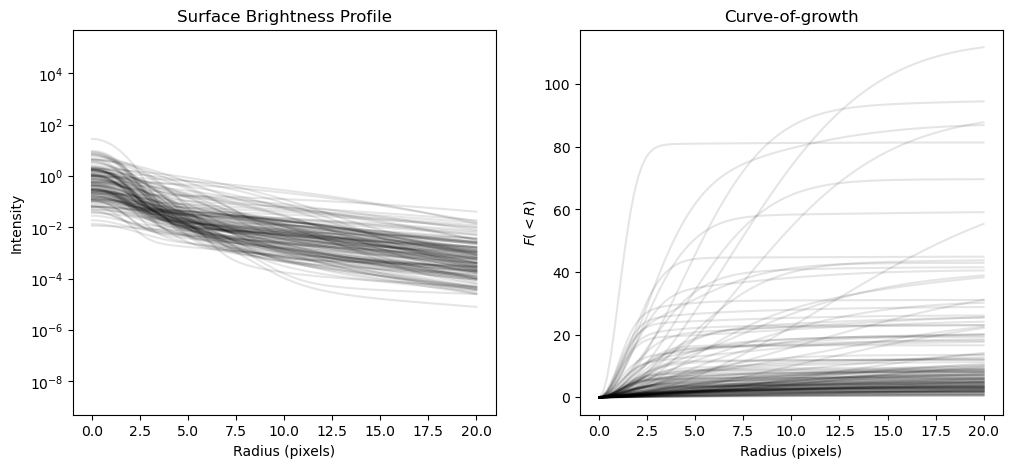

In [16]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(rplot, sbp_all[:,::100], 'k-', alpha = 0.1)

ax1.set_yscale('log')
ax1.set_ylim([5e-10,5e5])
ax1.set_title('Surface Brightness Profile')
ax1.set_xlabel('Radius (pixels)')
ax1.set_ylabel('Intensity')

ax2.plot(rplot,cog_all[:,::100], 'k-', alpha = 0.1)
ax2.set_title('Curve-of-growth')
ax2.set_xlabel('Radius (pixels)')
ax2.set_ylabel(r'$F(<R)$')
plt.show()

/var/folders/xm/sl735y1n4m30kfvcxl7h4p6w0000gn/T/ipykernel_39223/1717929621.py:15: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin=np.log10(data_min), vmax=np.log10(data_max))
/var/folders/xm/sl735y1n4m30kfvcxl7h4p6w0000gn/T/ipykernel_39223/1717929621.py:15: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin=np.log10(data_min), vmax=np.log10(data_max))
/var/folders/xm/sl735y1n4m30kfvcxl7h4p6w0000gn/T/ipykernel_39223/1717929621.py:17: RuntimeWarning: invalid value encountered in log10
  ax2.imshow(np.log10(best_fit_mod),vmin = -2, vmax =1)


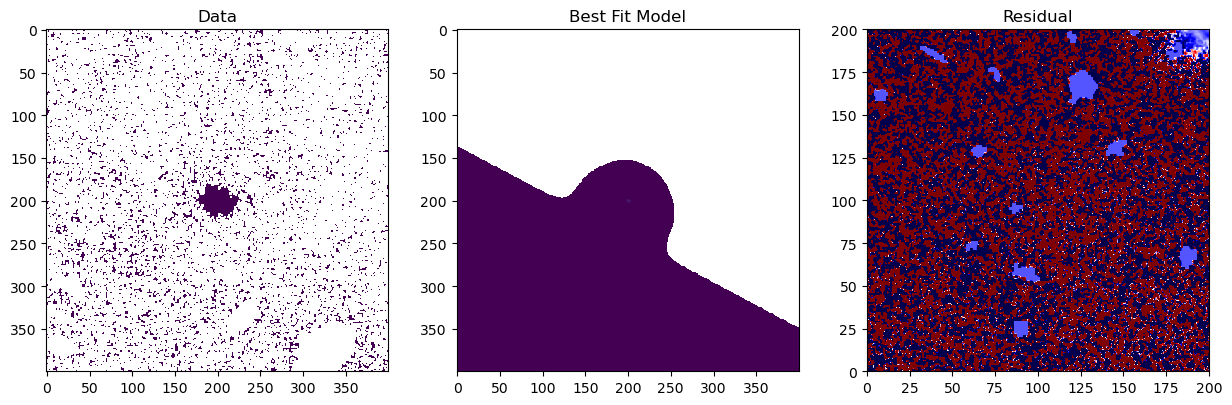

In [17]:
## Let's take a quick look at the best fit-model to make sure it looks god
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (15,5))

best_fit_mod = fitter.make_model(min_res) #generate a model image using the best fitting parameters

#Calculate the residual image and mask out the other sources
resid = (fitter.img - best_fit_mod)/best_fit_mod
resid *= np.logical_not(fitter.mask)

# Calculate data range for proper scaling
data_min = np.min(fitter.img * np.logical_not(mask))
data_max = np.max(fitter.img * np.logical_not(mask))

ax1.set_title('Data')
ax1.imshow(np.log10(fitter.img*np.logical_not(mask)),vmin=np.log10(data_min), vmax=np.log10(data_max))
ax2.set_title('Best Fit Model')
ax2.imshow(np.log10(best_fit_mod),vmin = -2, vmax =1)
ax3.set_title('Residual')
ax3.imshow(resid, vmin = -0.5, vmax = 1, cmap = 'seismic')
ax3.set_xlim([0,200])
ax3.set_ylim([0,200])

plt.show()

In [18]:
from imcascade import ImcascadeResults

#Initialized using fitter instance
ls_res = ImcascadeResults(fitter)

#Initialized with saved file
dyn_res = ImcascadeResults('examp_results.asdf')

In [19]:
#we can also specify the percentiles used to calculate the error bars, here we use the 5th-95th percentile
dyn_res.run_basic_analysis(zpt = 23.9, errp_lo = 16, errp_hi = 84) 

{'flux': array([ 7.41723479,  5.09974411, 21.03612497]),
 'mag': array([21.72439494,  1.4597288 ,  1.26306007]),
 'r20': array([1.75777925, 0.71344747, 2.06064242]),
 'r50': array([4.15436515, 2.16437405, 4.15729038]),
 'r80': array([9.87305498, 5.80746428, 6.94298401]),
 'r90': array([14.21506552,  7.90533655,  8.32173398]),
 'C80_20': array([4.09578647, 1.18268281, 3.4323952 ]),
 'C90_50': array([2.61258167, 0.63903849, 2.14286595])}

In [20]:
#Sets of radii to calculate profiles at
rplot = np.linspace(0, 80, num = 200)

#calulating the total surface brightness for each of 200 points
sbp_ls_tot = ls_res.calc_sbp(rplot)

# Using return_ind we return the contributions of each individual gaussian component
sbp_ls_ind = ls_res.calc_sbp(rplot,return_ind = True)

In [19]:
sbp_ls_tot

array([[1.49652992e+00, 7.27733924e-02, 6.22552833e-01, ...,
        1.11337703e-01, 2.74935712e-01, 4.62852686e-02],
       [1.40516839e+00, 6.82832941e-02, 6.10684490e-01, ...,
        1.04026440e-01, 2.66459760e-01, 4.42240616e-02],
       [1.17028549e+00, 5.66944615e-02, 5.76651042e-01, ...,
        8.52560856e-02, 2.42955701e-01, 3.87163463e-02],
       ...,
       [2.82488723e-13, 1.96775421e-13, 1.53677410e-13, ...,
        4.65110831e-13, 3.03140643e-13, 3.07048857e-13],
       [2.60779706e-13, 1.81652668e-13, 1.41888068e-13, ...,
        4.28828759e-13, 2.78766630e-13, 2.83119958e-13],
       [2.40644992e-13, 1.67626707e-13, 1.30950449e-13, ...,
        3.95261886e-13, 2.56328424e-13, 2.60978237e-13]])

In [20]:
#the posterier distribution of the surface_brightness profile
sbp_all = dyn_res.calc_sbp(rplot,)

#the curve-of-growth for the posterier
cog_all = dyn_res.calc_cog(rplot)

ValueError: x and y can be no greater than 2D, but have shapes (200,) and (200, 12975, 9)

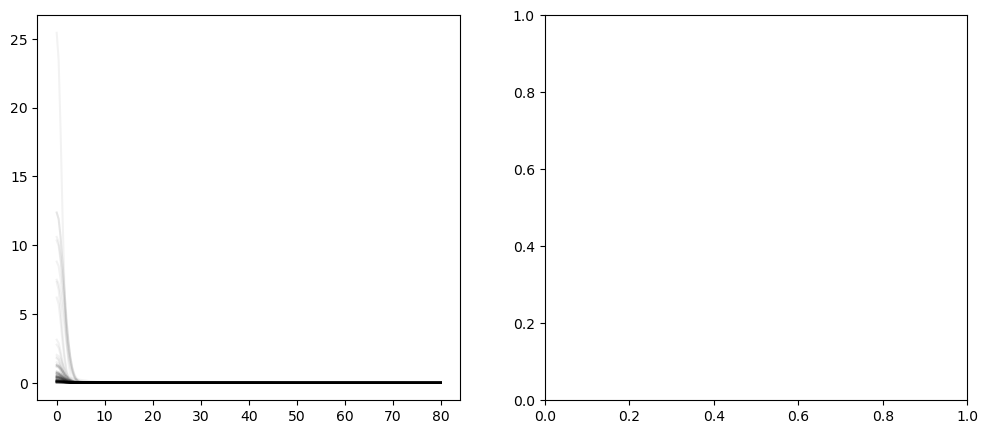

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (12,5))
ax1.plot(rplot, sbp_all[:,::100], 'k-', alpha = 0.05)
ax1.plot(rplot, sbp_ls_ind, 'r--', alpha = 0.05)

ax1.set_yscale('log')
ax1.set_ylim([5e-10,5e1])
ax1.set_title('Surface Brightness Profile')
ax1.set_xlabel('Radius (pixels)')
ax1.set_ylabel('Intensity')

ax2.plot(rplot,cog_all[:,::100], 'k-', alpha = 0.5)
ax2.set_title('Curve-of-growth')
ax2.set_xlabel('Radius (pixels)')
ax2.set_ylabel(r'$F(<R)$')
plt.show()

In [25]:
sbp_ls_ind

array([[[1.13557844e+000, 4.26086975e-003, 4.28450428e-002, ...,
         2.12087861e-007, 8.77439419e-009, 7.16177160e-010],
        [5.33954854e-002, 3.25107995e-003, 1.11053704e-002, ...,
         2.62238433e-006, 6.25940546e-009, 4.98849635e-010],
        [1.09038434e-002, 7.16404503e-003, 5.97397341e-001, ...,
         2.30088590e-006, 6.07445832e-010, 3.90276409e-010],
        ...,
        [9.17583229e-002, 6.42454486e-004, 5.86767082e-004, ...,
         5.35448205e-007, 1.23200947e-007, 1.16175460e-009],
        [1.00521636e-002, 1.87855072e-001, 9.41896046e-004, ...,
         9.95572354e-006, 2.27026552e-007, 7.33690892e-010],
        [1.31479271e-002, 2.72111244e-002, 3.01213336e-004, ...,
         4.90898262e-005, 7.66527509e-008, 7.67696415e-010]],

       [[1.04742641e+000, 4.10112976e-003, 4.20778373e-002, ...,
         2.11896339e-007, 8.77064648e-009, 7.16032496e-010],
        [4.92505315e-002, 3.12919699e-003, 1.09065118e-002, ...,
         2.62001624e-006, 6.25673195e-